In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv(r"E:\Kaiburr-DS\complaints-2025-09-21_04_41.csv")
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/28/25,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AR,72901,NaN,NaN,Web,08/28/25,In progress,Yes,NaN,15576155
1,09/01/25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,76040,NaN,NaN,Web,09/01/25,In progress,Yes,NaN,15636031
2,08/27/25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,33319,NaN,NaN,Web,08/27/25,In progress,Yes,NaN,15549463
3,07/11/25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,I did not initiate these inquiries and believe...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,761XX,NaN,Consent provided,Web,07/11/25,Closed with non-monetary relief,Yes,NaN,14595898
4,07/24/25,Mortgage,FHA mortgage,Struggling to pay mortgage,Trying to communicate with the company to fix ...,NaN,NaN,"AmeriHome Mortgage Company, LLC",FL,34983,NaN,NaN,Web,08/01/25,In progress,Yes,NaN,14869942


In [3]:
df.shape

(1511771, 18)

In [4]:
df.columns.tolist()

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

In [5]:
pd.set_option('display.max_colwidth', None)
print("Unique product names:")
print(df['Product'].unique())
pd.reset_option('display.max_colwidth')

narratives = df['Consumer complaint narrative'].dropna()
if len(narratives) > 0:
    print("\nFirst complaint example:")
    print(narratives.iloc[0])
else:
    print("\nNo complaints found!")

print("\nMissing in Product:", df['Product'].isnull().sum())
print("Missing in Complaint:", df['Consumer complaint narrative'].isnull().sum())
print("Total rows:", len(df))

Unique product names:
['Credit reporting or other personal consumer reports' 'Mortgage'
 'Debt collection' 'Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Payday loan, title loan, personal loan, or advance loan' 'Student loan'
 'Vehicle loan or lease' 'Debt or credit management' 'Prepaid card']

First complaint example:
I did not initiate these inquiries and believe they may involve unauthorized activity. Kindly investigate this issue and take corrective action promptly. The documentation is enclosed for your reference.

Missing in Product: 0
Missing in Complaint: 1381125
Total rows: 1511771


In [6]:
# Map products to categories
category_map = {
    'Credit reporting or other personal consumer reports': 0,
    'Debt collection': 1,
    'Payday loan, title loan, personal loan, or advance loan': 2,
    'Student loan': 2,
    'Vehicle loan or lease': 2,
    'Mortgage': 3
}

df['category'] = df['Product'].map(category_map)

# Check how many records in each category
print("Category counts (with NaN included):")
print(df['category'].value_counts(dropna=False))


Category counts (with NaN included):
category
0.0    1374168
1.0      71639
NaN      49052
2.0      11592
3.0       5320
Name: count, dtype: int64


In [7]:
# Keeping only rows with mapped categories
df = df.dropna(subset=['category'])

# Drop rows without complaint text
before = len(df)
df = df.dropna(subset=['Consumer complaint narrative'])
after = len(df)

print("Dropped", before - after, "rows with empty complaints")
print("Final shape:", df.shape)

# Class distribution
print("\nClass counts:")
print(df['category'].value_counts())

print("\nClass %:")
print((df['category'].value_counts(normalize=True) * 100).round(2))


Dropped 1345129 rows with empty complaints
Final shape: (117590, 19)

Class counts:
category
0.0    102015
1.0     10633
2.0      3117
3.0      1825
Name: count, dtype: int64

Class %:
category
0.0    86.75
1.0     9.04
2.0     2.65
3.0     1.55
Name: proportion, dtype: float64


In [8]:
#Checking for NULL Values
print("Null check for CRITICAL columns:")
print(f"- 'Consumer complaint narrative' nulls: {df['Consumer complaint narrative'].isnull().sum()}")
print(f"- 'category' nulls: {df['category'].isnull().sum()}")
print(f"- Total rows in dataset: {len(df)}")

Null check for CRITICAL columns:
- 'Consumer complaint narrative' nulls: 0
- 'category' nulls: 0
- Total rows in dataset: 117590


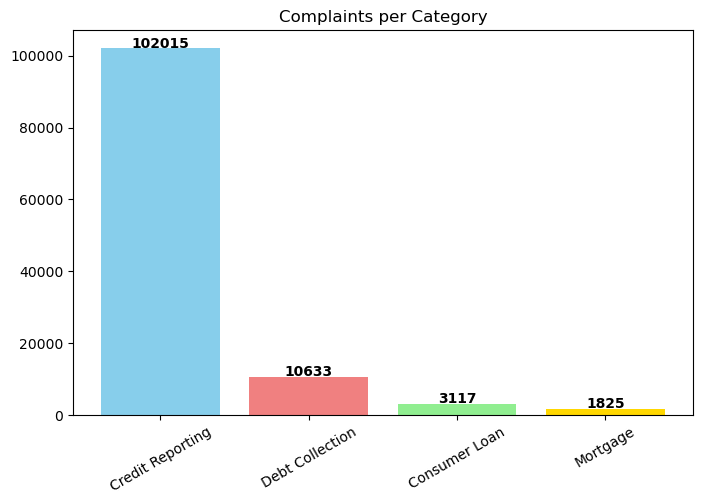


Text stats by category:
          char_count  word_count
category                        
0.0            703.0       119.0
1.0            693.0       120.0
2.0           1037.0       179.0
3.0           1276.0       218.0

Created extra features: char_count, word_count, avg_word_len, unique_word_ratio


In [9]:
category_names = ['Credit Reporting', 'Debt Collection', 'Consumer Loan', 'Mortgage']
counts = df['category'].value_counts().sort_index()

plt.figure(figsize=(8,5))
bars = plt.bar(category_names, counts, color=['skyblue','lightcoral','lightgreen','gold'])
plt.title("Complaints per Category")
plt.xticks(rotation=30)

# add counts on top
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+200, str(count), 
             ha='center', fontweight='bold')

plt.show()

df['char_count'] = df['Consumer complaint narrative'].str.len()
df['word_count'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))

print("\nText stats by category:")
print(df.groupby('category')[['char_count','word_count']].median())

# Made a couple of extra features
df['avg_word_len'] = df['Consumer complaint narrative'].apply(
    lambda x: np.mean([len(w) for w in x.split()]) if len(x.split())>0 else 0
)
df['unique_word_ratio'] = df['Consumer complaint narrative'].apply(
    lambda x: len(set(x.split()))/len(x.split()) if len(x.split())>0 else 0
)

print("\nCreated extra features: char_count, word_count, avg_word_len, unique_word_ratio")


In [10]:
# text cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        nltk.download('wordnet')
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    
    return ' '.join(words)

print("Cleaning text data...")
df['cleaned_text'] = df['Consumer complaint narrative'].apply(clean_text)

print("Sample of original vs cleaned text:")
print("Original:", df['Consumer complaint narrative'].iloc[0][:100] + "...")
print("Cleaned: ", df['cleaned_text'].iloc[0][:100] + "...")
print("Text preprocessing completed!")


Cleaning text data...
Sample of original vs cleaned text:
Original: I did not initiate these inquiries and believe they may involve unauthorized activity. Kindly invest...
Cleaned:  initiate inquiry believe may involve unauthorized activity kindly investigate issue take corrective ...
Text preprocessing completed!


In [11]:
# features and target
X = df['cleaned_text']
y = df['category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# convert text to numbers
print("Converting text to numerical features...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# balance training data using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

print(f"Training features shape: {X_train_res.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
    'Naive Bayes': MultinomialNB(),
}

print("Data ready for model training!")


Converting text to numerical features...
Training features shape: (326448, 5000)
Testing features shape: (23518, 5000)
Data ready for model training!


In [12]:
# Train and evaluate each model after SMOTE
for name, model in models.items():
    print(f"\nTraining {name}:")
    model.fit(X_train_res, y_train_res)  
    y_pred = model.predict(X_test_tfidf) 
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-"*60)


Training Logistic Regression:
Logistic Regression Accuracy: 0.9137

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95     20403
         1.0       0.61      0.85      0.71      2127
         2.0       0.49      0.82      0.62       623
         3.0       0.76      0.89      0.82       365

    accuracy                           0.91     23518
   macro avg       0.71      0.87      0.77     23518
weighted avg       0.94      0.91      0.92     23518

------------------------------------------------------------

Training Naive Bayes:
Naive Bayes Accuracy: 0.8683

Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     20403
         1.0       0.54      0.74      0.62      2127
         2.0       0.31      0.88      0.46       623
         3.0       0.56      0.96      0.71       365

    accuracy                    

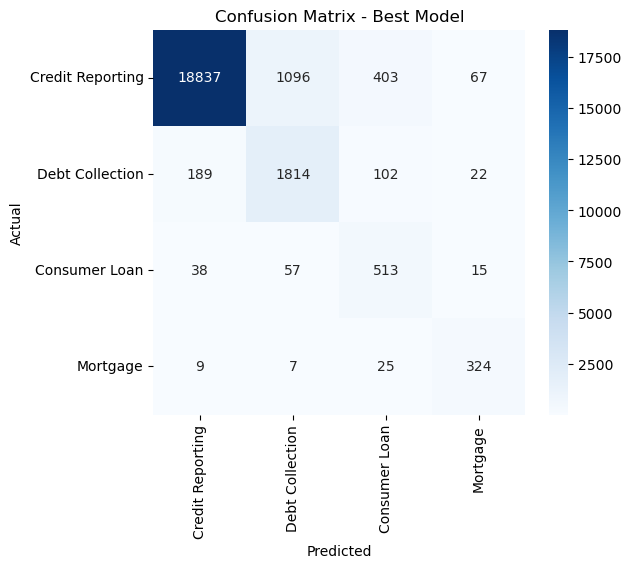

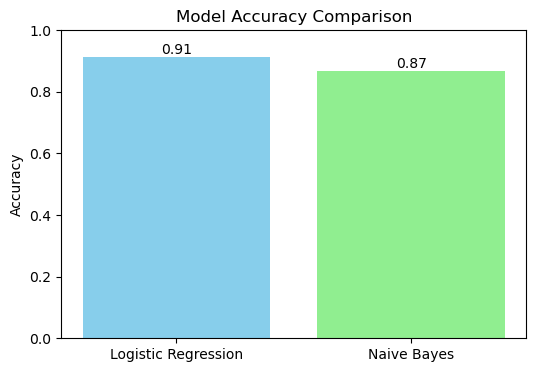

In [13]:
# picking the best model
best_model = models['Logistic Regression']

y_pred = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
category_names = ['Credit Reporting', 'Debt Collection', 'Consumer Loan', 'Mortgage']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=category_names, yticklabels=category_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model')
plt.show()

model_names = []
accuracies = []

for name, model in models.items():
    y_pred_model = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred_model)
    model_names.append(name)
    accuracies.append(acc)

plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies, color=['skyblue','lightgreen','lightcoral'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i, v in enumerate(accuracies):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center')
plt.show()

In [14]:
#Prediction
new_complaints = [
    "I am being called by a debt collector every day",
    "My credit report has wrong information",
    "I need help with my student loan payment",
    "I am having trouble with my mortgage company"
]

cleaned_new = [clean_text(text) for text in new_complaints]

X_new_tfidf = vectorizer.transform(cleaned_new)

# predict categories
predictions = best_model.predict(X_new_tfidf)

# map numeric categories back to names
category_names = ['Credit Reporting', 'Debt Collection', 'Consumer Loan', 'Mortgage']
pred_category_names = [category_names[int(p)] for p in predictions]

for text, cat in zip(new_complaints, pred_category_names):
    print("Complaint:", text)
    print("Predicted Category:", cat)
    print("-"*60)


Complaint: I am being called by a debt collector every day
Predicted Category: Debt Collection
------------------------------------------------------------
Complaint: My credit report has wrong information
Predicted Category: Credit Reporting
------------------------------------------------------------
Complaint: I need help with my student loan payment
Predicted Category: Consumer Loan
------------------------------------------------------------
Complaint: I am having trouble with my mortgage company
Predicted Category: Mortgage
------------------------------------------------------------
